In [88]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_device():
    """Return the available device: GPU if available, otherwise CPU."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

In [61]:
data_dir = os.getcwd()  # You can change this to your desired directory
transform = transforms.ToTensor()

train_dataset = EMNIST(root=data_dir, split="byclass", train=True, download=True, transform=transform)
test_dataset = EMNIST(root=data_dir, split="byclass", train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle test data


# Model Definition

In [74]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 300)
        self.fc2 = nn.Linear(300, 250)
        self.fc3 = nn.Linear(250, 150)
        self.fc4 = nn.Linear(150, 62)
        self.activation = nn.LeakyReLU()
    
    def forward(self, x):
        # Flatten the input tensor while preserving the batch size
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# Training Setup

In [92]:
device = get_device()
model = Classifier().to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 10
train_losses = []
val_losses = []

# Training Loop

In [93]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Multiply by the batch size to get the total loss for this batch
        running_train_loss += loss.item() * features.size(0)
    
    # Compute average training loss over the epoch
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * features.size(0)
    
    epoch_val_loss = running_val_loss / len(test_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

0.11822862803181394 0.10828773217605296
0.08802410793407746 0.06840670175715437
0.05876018309519004 0.05114921783542762
0.0474256620744585 0.04422717805415953
0.042321416764122065 0.04046243891938142
0.039126657637132654 0.03764921192449644
0.03665180338685273 0.03536363381489211
0.03451300966712531 0.03334301397202221
0.03262745127468143 0.0316128454761117
0.0309681009327661 0.030065200174961525


# Plot Loss Curves

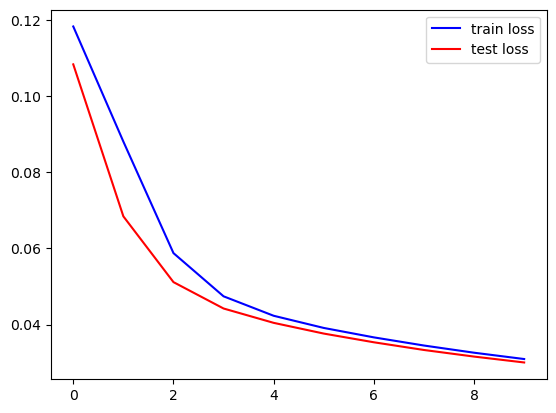

In [94]:
plt.figure()
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

# Evaluation and Metrics

In [95]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for features, targets in test_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Create and plot the confusion matrix
classes = train_dataset.classes  # List of class names
cm = confusion_matrix(all_targets, all_preds)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report

In [ ]:
print(classification_report(all_targets, all_preds, target_names=classes, zero_division=0))